# Titanic
Kaggleの[Titanic](https://www.kaggle.com/competitions/titanic/overview)問題に取り組む。与えられたデータから精度の高い乗客の生存予測モデルを構築する。その際、[Kaggleで勝つデータ分析の技術](https://www.amazon.co.jp/s?k=kaggle%E3%81%A7%E5%8B%9D%E3%81%A4%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90%E3%81%AE%E6%8A%80%E8%A1%93&adgrpid=77287830145&gclid=Cj0KCQjwspKUBhCvARIsAB2IYutwvwskzyUMsH_7BhCFt1YZQMP3NhcrHUWphOAfORCbpIhG7BxFEPoaAuL9EALw_wcB&hvadid=553974449198&hvdev=c&hvlocphy=1009798&hvnetw=g&hvqmt=e&hvrand=5178349908727401306&hvtargid=kwd-818170082585&hydadcr=27492_14478797&jp-ad-ap=0&tag=googhydr-22&ref=pd_sl_3dob3l12xf_e)を参考にした。  
![](https://i.imgur.com/rRFchA8.png)

# 目次
0. ライブラリ・データの読み込み
1. データの外観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブル
6. 予測の出力・提出
7. 結果
8. 感想

## 0. ライブラリ・データの読み込み

### 0.1 ライブラリの読み込み

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

### 0.2 データの読み込み

In [2]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

## 1. データの外観・分析・前処理

### 1.1 データの外観

In [3]:
# データサイズの確認
print('訓練データのデータ数は{}、変数は{}種類'.format(df.shape[0], df.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類
テストデータのデータ数は418、変数は11種類


In [4]:
# 訓練データの初めの5データ
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 変数名の一覧
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

変数名を[Data Dictionary](https://www.kaggle.com/competitions/titanic/data)に示された変数の説明と対応づける。

Variable | Definition | Key
---|---|---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex
Age | Age in years
sibsp | # of siblings / spouses aboard the Titanic
parch | # of parents / children aboard the Titanic
ticket | Ticket number
fare | Passenger fare
cabin | Cabin number
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

### 1.2 データの分析

In [6]:
# データの型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


数値データ：Passengerld, Survived, Pclass, Age, SibSp, Parch, Fare  
カテゴリカルデータ：Name, Sex, Ticket, Cabin, Embarked

In [7]:
# 欠損値の確認
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

訓練データはAge, Cabin, Embarkedの値の一部が欠損していることがわかる。

In [8]:
# 欠損値の確認
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

テストデータはAge, Fare, Cabinの値の一部が欠損していることがわかる。

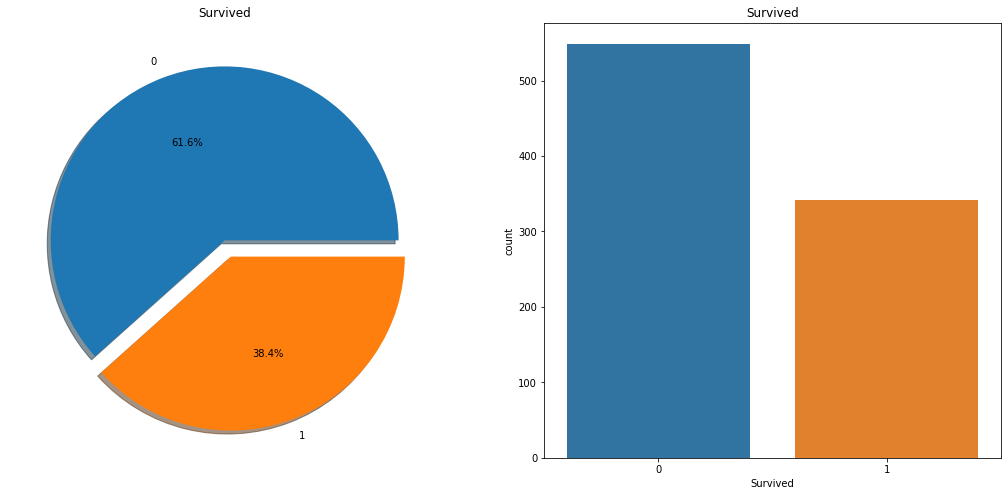

In [9]:
# Survived
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

生存率は38.4%であることがわかる。予測対象であるSurvivedは生存：死亡がおよそ4：6と均衡しているといえる。

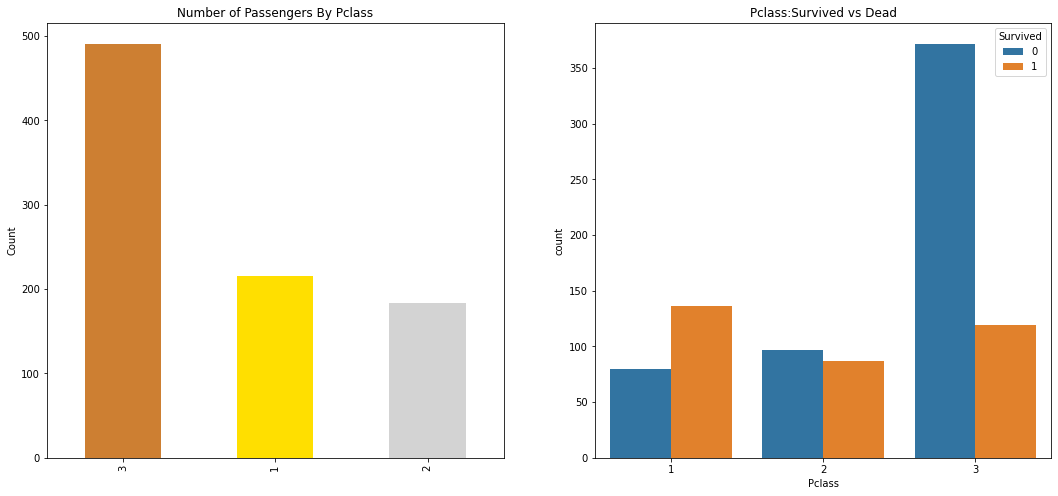

In [10]:
# Pclass
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

Pclassごとに人数及び死亡率が異なっていることがわかる。特にPclass=3は人数が圧倒的に多く、死亡率も高いことがわかる。一方でPclass=1は死亡率が非常に低くなっている。Pclassはチケットのクラスであることから、Pclassの値が小さいほどチケットのグレードが高いことを示唆している。

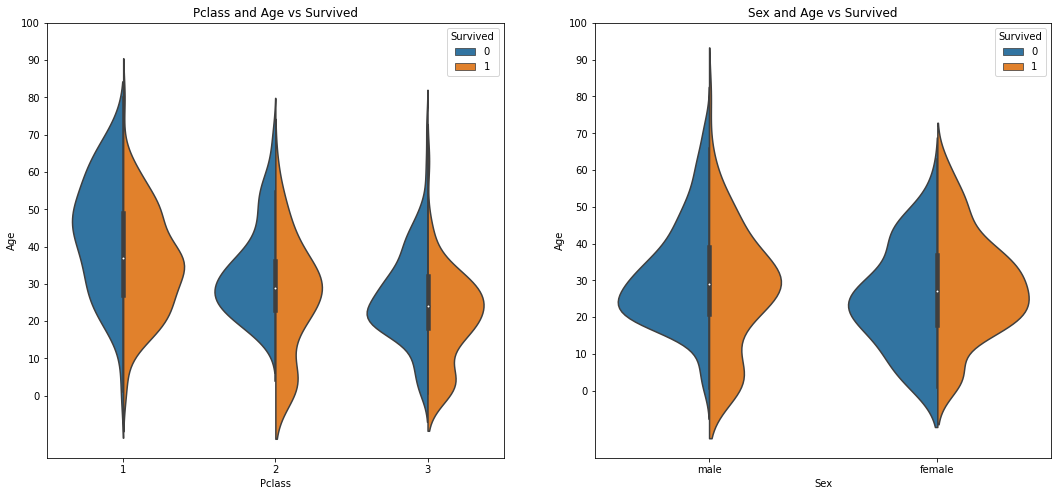

In [11]:
# Age
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot('Pclass','Age', hue='Survived', data=df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex','Age', hue='Survived', data=df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

10歳以下の子供の数はPclassの値が増えるごとに増加し、生存率はPclassに関係なく良好であることがわかる。20~50歳の女性の生存率が高いことがわかる。

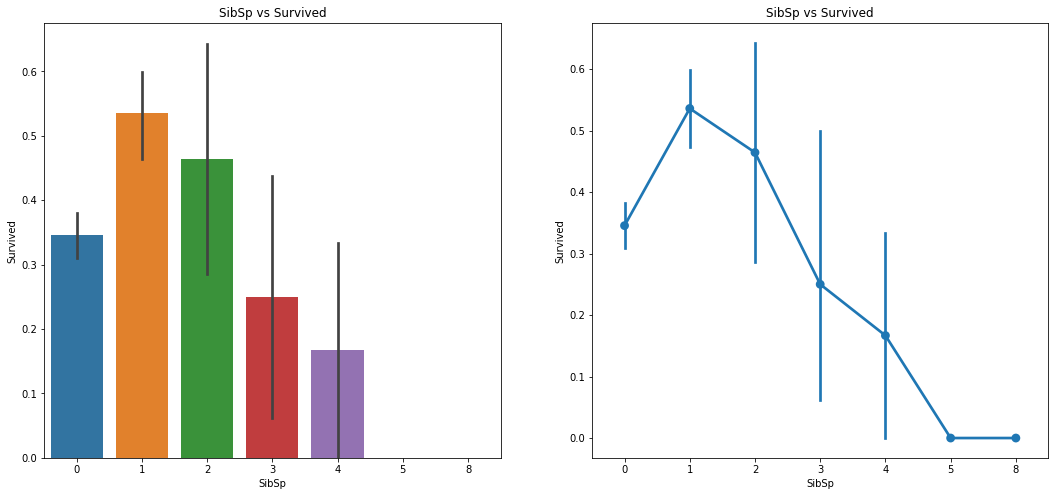

In [12]:
# SibSp
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.barplot('SibSp','Survived',data=df,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.pointplot('SibSp','Survived',data=df,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.show()

兄弟姉妹・配偶者がいない乗客の生存率はおよそ35%であることがわかる。  
兄弟姉妹・配偶者が5~8人同乗している場合、生存率が0%であることがわかる。  
また、兄弟姉妹・配偶者の数が増えると、グラフは減少することがわかる。  

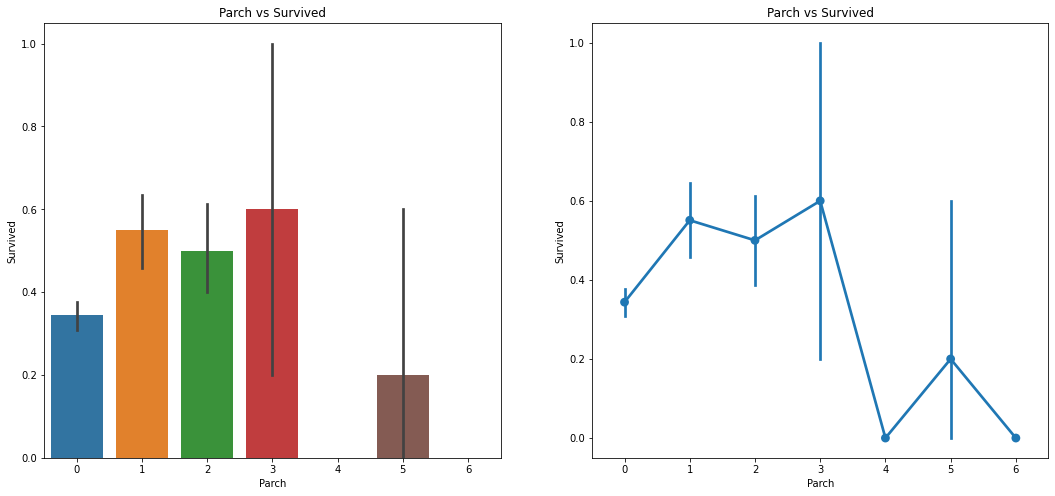

In [13]:
# Parch
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.barplot('Parch','Survived',data=df,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.pointplot('Parch','Survived',data=df,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.show()

親・子供が4~6人同乗している場合を除いて、親・子供が同乗している乗客の方が生存率が高いことがわかる。4人以上の親・子供が同乗していると生存の可能性が減少することがわかる。 

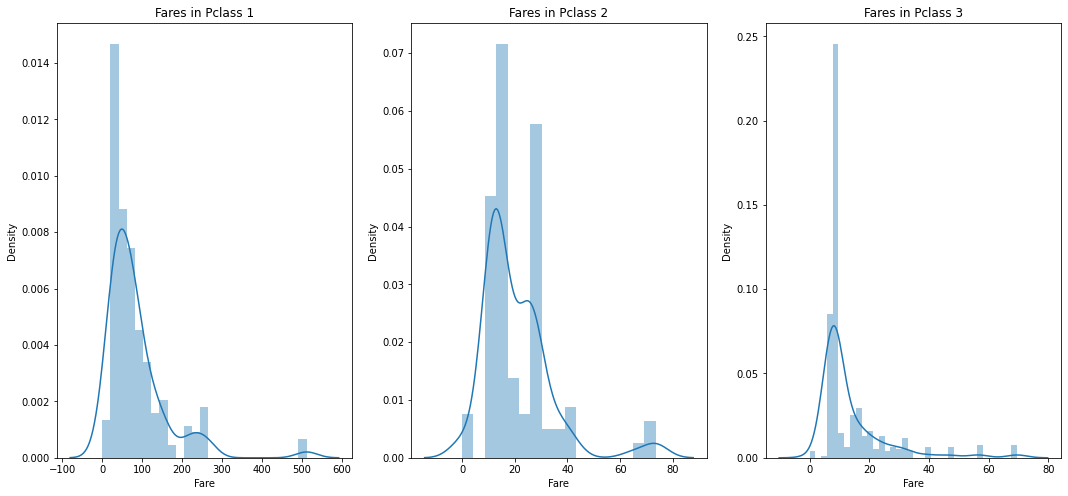

In [14]:
# Fare
f,ax=plt.subplots(1,3,figsize=(18,8))
sns.distplot(df[df['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(df[df['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(df[df['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

Pclass=1の乗客の運賃には大きな分布があり、Pclassの値が大きくなるほど、分布が小さくなっていることがわかる。

In [15]:
# Name
df['Name'].count()

891

In [16]:
len(df['Name'].unique())

891

count数の値とunique数の値が同じであることがわかる。

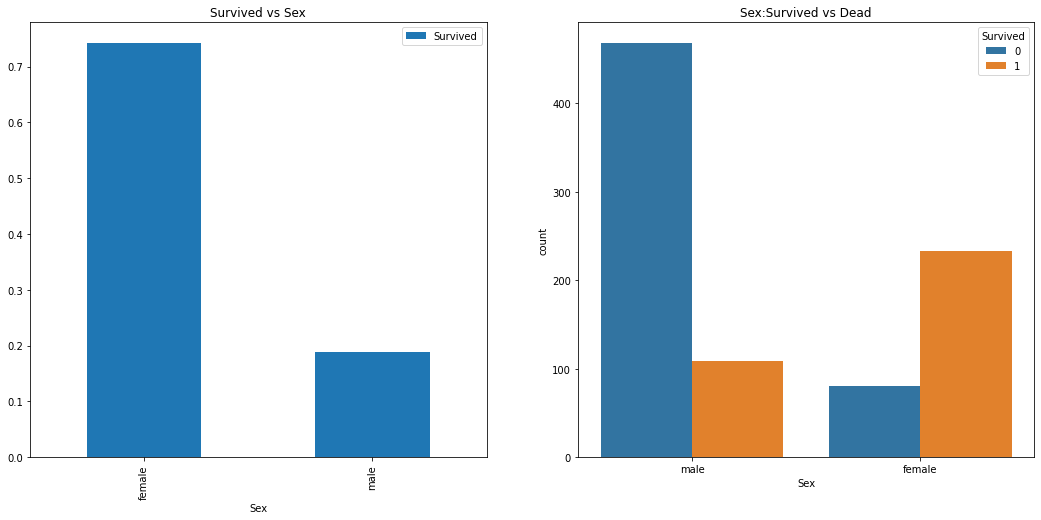

In [17]:
# Sex
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

男性の方が女性よりもはるかに多くの数の人が乗船しているにも関わらず、生存した女性の数は男性の数のおよそ2倍であることがわかる。

In [18]:
# Ticket
df['Ticket'].count()

891

In [19]:
len(df['Ticket'].unique())

681

count数の値とunique数の値が同じでないため、完全にユニークではないことがわかる。

In [20]:
# Cabin
df['Cabin'].count()

204

In [21]:
len(df['Cabin'].unique())

148

count数の値とunique数の値が同じでないため、完全にユニークではないことがわかる。

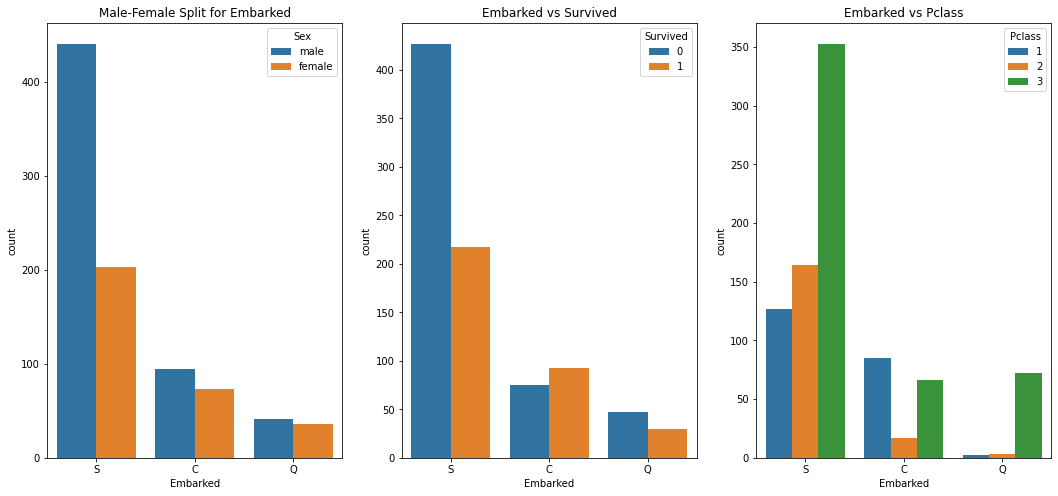

In [22]:
# Embarked
f,ax=plt.subplots(1,3,figsize=(18,8))
sns.countplot('Embarked',hue='Sex',data=df,ax=ax[0])
ax[0].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=df,ax=ax[1])
ax[1].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=df,ax=ax[2])
ax[2].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

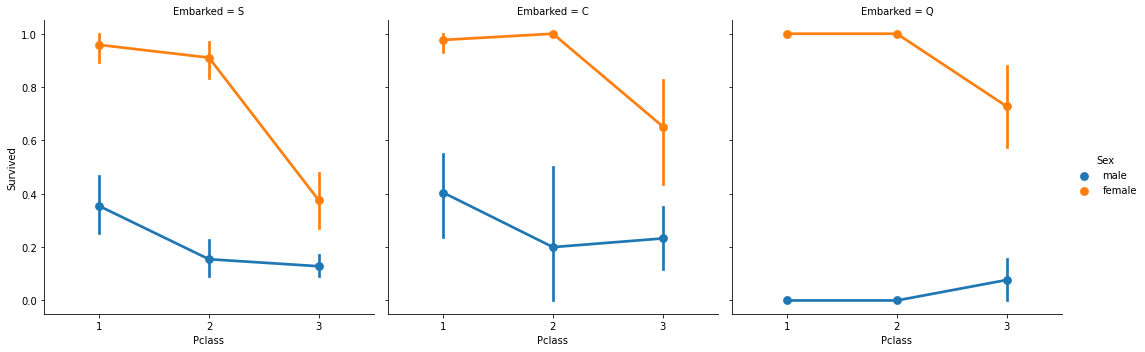

In [23]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=df)
plt.show()

Embarkedの値がS, C, Qの順に乗客が多いことがわかる。  
Embarked=Sは男女ともに生存率が低いことがわかる。  
Embarked=SはほとんどがPclass=3であることがわかる。  
Pclass=1, 2ではEmbarkedの値に関係なく女性の生存率はおよそ1であることがわかる。  

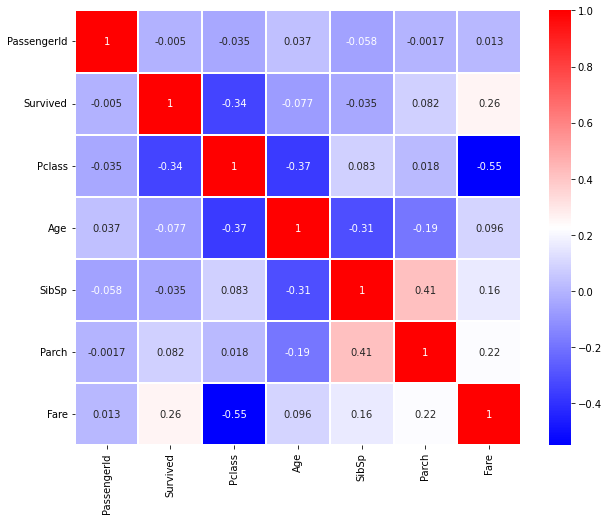

In [24]:
# 相関行列
sns.heatmap(df.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

SibSpとParchの値に比較的強い正の相関があることがわかる。  
PclassとFareの値に比較的強い負の相関があることがわかる。

### 1.3 データの前処理

#### 1.3.1 欠損値の補完

Age：敬称ごとの年齢の平均値で補完する。

In [25]:
# Nameから敬称を取り出す
title_list = []

for name in df["Name"]:
    for name_split in name.split():
        if name_split.endswith(".") == True:
            if name_split != "L.":
                title_list.append(name_split)

title_unique = set(title_list)      

print(title_unique)

{'Capt.', 'Mrs.', 'Dr.', 'Mr.', 'Ms.', 'Lady.', 'Countess.', 'Mlle.', 'Miss.', 'Col.', 'Sir.', 'Master.', 'Rev.', 'Mme.', 'Major.', 'Don.', 'Jonkheer.'}


<AxesSubplot:xlabel='Title', ylabel='Survived'>

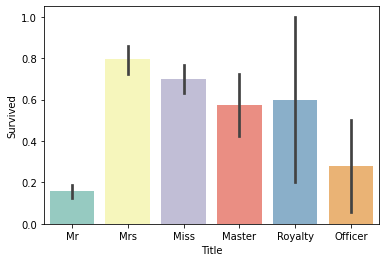

In [26]:
# Nameから新たな特徴量Titleを作り出す
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona', 'Jonkheer'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

In [27]:
# Nameから新たな特徴量Titleを作り出す
df_test['Title'] = df_test['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df_test['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_test['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona', 'Jonkheer'], 'Royalty', inplace=True)
df_test['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_test['Title'].replace(['Mlle'], 'Miss', inplace=True)

In [28]:
# TitleごとのAgeの平均値を代入
df.loc[df['Age'].isnull(), 'Age'] = df.groupby('Title')['Age'].transform('mean')
df_test.loc[df_test['Age'].isnull(), 'Age'] = df_test.groupby('Title')['Age'].transform('mean')

Fare：PclassごとのFareの平均値で補完する。

In [29]:
# PclassごとのFareの平均値を代入
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test.groupby('Pclass')['Fare'].transform('mean')

Cabin：欠損値の数が全体の8割近いため、削除する。

In [30]:
# Cabinを削除
df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

Embarked：Sが圧倒的に多いため、Sで補完する。

In [31]:
# Sを代入
df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

#### 1.3.2 カテゴリカルデータの処理

Name：Title(敬称)を用いてOne-Hot Encodingをする。

In [32]:
title = pd.concat([df['Title'], df_test['Title']])
title_ohe = pd.get_dummies(title)

title_ohe_train = title_ohe[:891]
title_ohe_test = title_ohe[891:]

df = pd.concat([df, title_ohe_train], axis=1)
df_test = pd.concat([df_test, title_ohe_test], axis=1)

df.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
df.drop('Title', axis=1, inplace=True)
df_test.drop('Title', axis=1, inplace=True)

Sex：男性を0、女性を1に変換する。

In [33]:
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

Ticket：Ticketの値が同じ場合、1つのグループだと仮定して新たな特徴量Groupを作り出す。  
Groupを用いてFalseを0、Trueを1に変換する。

In [34]:
df['Group'] = df.duplicated(subset=['Ticket'])
df_test['Group'] = df_test.duplicated(subset=['Ticket'])
df['Group'] = df['Group'].astype(int)
df_test['Group'] = df_test['Group'].astype(int)

df.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

Embarked：One-Hot Encodingをする。

In [35]:
embarked = pd.concat([df['Embarked'], df_test['Embarked']])

embarked_ohe = pd.get_dummies(embarked)

embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_test = embarked_ohe[891:]

df = pd.concat([df, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

In [36]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,Officer,Royalty,Group,C,Q,S
0,1,0,3,0,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,0,0,0,1,0,0,0,1,0,0
2,3,1,3,1,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,1


In [37]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,Officer,Royalty,Group,C,Q,S
0,892,3,0,34.5,0,0,7.8292,0,0,1,0,0,0,0,0,1,0
1,893,3,1,47.0,1,0,7.0000,0,0,0,1,0,0,0,0,0,1
2,894,2,0,62.0,0,0,9.6875,0,0,1,0,0,0,0,0,1,0
3,895,3,0,27.0,0,0,8.6625,0,0,1,0,0,0,0,0,0,1
4,896,3,1,22.0,1,1,12.2875,0,0,0,1,0,0,0,0,0,1


### 2. ベースラインモデルの構築

説明変数：PassengerId、Survived以外の変数  
目的変数：Survived

In [38]:
# 説明変数と目的変数に分割
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

In [39]:
# ホールドアウト法によるバリデーション
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

モデル：GBDT

In [40]:
# 訓練データを5分割したクロスバリデーションでハイパーパラメータ探索
param_grid = {'min_child_weight':[1, 2, 3, 4, 5], 'max_depth':[3, 5, 7, 9], 'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1.0], 'subsample':[0.6, 0.7, 0.8, 0.9, 1.0]}

xgbc_gs = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5)
xgbc_gs.fit(X, y)

print('Best Parameters: {}'.format(xgbc_gs.best_params_))
print('CV Score: {}'.format(round(xgbc_gs.best_score_, 3)))

Best Parameters: {'colsample_bytree': 1.0, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
CV Score: 0.849


In [41]:
xgbc = xgb.XGBClassifier(**xgbc_gs.best_params_)
xgbc.fit(X_train, y_train)

print('XGBoost Classifier \n')
print('Train Score: {}'.format(round(xgbc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(xgbc.score(X_valid, y_valid), 3)))

XGBoost Classifier 

Train Score: 0.92
 Test Score: 0.828


### 3. 特徴量エンジニアリング

SibSpとParchの2つの値の和をとってFamiliy(同乗していた家族の人数)という新たな特徴量を作り出す。

In [42]:
df_fe = df.copy()
df_fe_test = df_test.copy()

df_fe['Family'] = df['SibSp'] + df['Parch']
df_fe_test['Family'] = df_test['SibSp'] + df_test['Parch']

df_fe.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Master,Miss,Mr,Mrs,Officer,Royalty,Group,C,Q,S,Family
0,1,0,3,0,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,1,1
1,2,1,1,1,38.0,1,0,71.2833,0,0,0,1,0,0,0,1,0,0,1
2,3,1,3,1,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,0,1,0
3,4,1,1,1,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,0,1,1
4,5,0,3,0,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,1,0


In [43]:
# 説明変数と目的変数に分割
X_fe = df_fe.iloc[:, 2:].values
y_fe = df_fe.iloc[:, 1].values

X_fe_test = df_fe_test.iloc[:, 1:].values

In [44]:
# ホールドアウト法によるバリデーション
X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

In [45]:
# 訓練データを5分割したクロスバリデーションでハイパーパラメータ探索
param_grid = {'min_child_weight':[1, 2, 3, 4, 5], 'max_depth':[3, 5, 7, 9], 'colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1.0], 'subsample':[0.6, 0.7, 0.8, 0.9, 1.0]}

xgbc_gs_fe = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=5)
xgbc_gs_fe.fit(X_fe, y_fe)

print('Best Parameters: {}'.format(xgbc_gs_fe.best_params_))
print('CV Score: {}'.format(round(xgbc_gs_fe.best_score_, 3)))

Best Parameters: {'colsample_bytree': 1.0, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.7}
CV Score: 0.846


In [46]:
xgbc_fe = xgb.XGBClassifier(**xgbc_gs_fe.best_params_)
xgbc_fe.fit(X_fe_train, y_fe_train)

print('fe_XGBoost Classifier \n')
print('Train Score: {}'.format(round(xgbc_fe.score(X_fe_train, y_fe_train), 3)))
print(' Test Score: {}'.format(round(xgbc_fe.score(X_fe_valid, y_fe_valid), 3)))

fe_XGBoost Classifier 

Train Score: 0.915
 Test Score: 0.817


精度が下がってしまったため、採用しない。

### 4. 様々なモデルの構築・調整

モデル：多層パーセプトロン

In [47]:
# 訓練データを5分割したクロスバリデーションでハイパーパラメータ探索
param_grid = {'hidden_layer_sizes':[(256, 256), (256, 256, 256), (256, 256, 256, 256)],
             'learning_rate':['invscaling', 'adaptive', 'constant'],
             'activation':['logistic', 'identity', 'relu', 'tanh']}
mlpc_gs = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=5)
mlpc_gs.fit(X, y)

print('Best Parameters: {}'.format(mlpc_gs.best_params_))
print('CV Score: {}'.format(round(mlpc_gs.best_score_, 3)))

Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (256, 256, 256), 'learning_rate': 'invscaling'}
CV Score: 0.824


In [48]:
# MLPClassifier
mlpc = MLPClassifier(**mlpc_gs.best_params_)
mlpc.fit(X_train, y_train)

print('MLP Classifier \n')
print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
print('Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

MLP Classifier 

Train Score: 0.833
Test Score: 0.813


モデル：ロジスティック回帰

In [49]:
# 訓練データを5分割したクロスバリデーションでハイパーパラメータ探索
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100]}

lr_gs = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
lr_gs.fit(X, y)

print('Best Parameters: {}'.format(lr_gs.best_params_))
print('CV Score: {}'.format(round(lr_gs.best_score_, 3)))

Best Parameters: {'C': 10}
CV Score: 0.826


In [50]:
# ロジスティック回帰モデルを作成し、疑似訓練データ(X_train, y_train)を学習させる
lr = LogisticRegression(**lr_gs.best_params_)
lr.fit(X_train, y_train)

print('Logistic Regression \n')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print('Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

Logistic Regression 

Train Score: 0.831
Test Score: 0.825


モデル：ランダムフォレスト

In [51]:
# 訓練データを5分割したクロスバリデーションでハイパーパラメータ探索
param_grid = {'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4]}

rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)

print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4}
CV Score: 0.827


In [52]:
# ランダムフォレストモデルを作成し、疑似訓練データ(X_train, y_train)を学習させる
rfc = RandomForestClassifier(**rfc_gs.best_params_)
rfc.fit(X_train, y_train)

print('Random Forest Classifier \n')
print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print('Test Score: {}'.format(round(rfc.score(X_valid, y_valid), 3)))

Random Forest Classifier 

Train Score: 0.856
Test Score: 0.832


### 5. モデルのアンサンブル

今回は単純に4つのモデルの予測値の算術平均を四捨五入して予測とする。

In [53]:
xgbc_proba = xgbc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
lr_proba = lr.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)
ensemble_proba = (xgbc_proba + mlpc_proba + lr_proba + rfc_proba) / 4

### 6. 予測の出力・提出

単一モデル(xgbc、mlpc、lr、rfc)とアンサンブルモデルの予測をそれぞれ出力し、提出する。

In [54]:
# xgbc
xgbc_pred = xgbc_proba.argmax(axis=1)
xgbc_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
xgbc_submission['Survived'] = xgbc_pred

xgbc_submission.to_csv('data/xgbc_submission.csv', index=False)

In [55]:
# mlpc
mlpc_pred = mlpc_proba.argmax(axis=1)
mlpc_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
mlpc_submission['Survived'] = mlpc_pred

mlpc_submission.to_csv('data/mlpc_submission.csv', index=False)

In [56]:
# lr
lr_pred = lr_proba.argmax(axis=1)
lr_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
lr_submission['Survived'] = lr_pred

lr_submission.to_csv('data/lr_submission.csv', index=False)

In [57]:
# rfc
rfc_pred = rfc_proba.argmax(axis=1)
rfc_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
rfc_submission['Survived'] = rfc_pred

rfc_submission.to_csv('data/rfc_submission.csv', index=False)

In [58]:
# ensemble
ensemble_pred = ensemble_proba.argmax(axis=1)
ensemble_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
ensemble_submission['Survived'] = ensemble_pred

ensemble_submission.to_csv('data/ensemble_submission.csv', index=False)

### 7. 結果

モデル | Score 
---|---|
xgbc | 0.73684
mlpc | 0.77272
lr | 0.77033
rfc | 0.77751
ensemble | 0.76794

4つのモデルをアンサンブルしたモデルが1番精度が高いと予想していたが、ランダムフォレスト単一モデルが最も精度が高かった。   
GBDT(xgbc)とランダムフォレスト(rfc)が決定木モデルとして手法が被ったのが良くなかったのではないかと仮説を立てた。  
そこで、GBDT(xgbc)モデルを除いたアンサンブル学習を行なってみる。

In [59]:
# ensemble2
ensemble2_proba = (mlpc_proba + lr_proba + rfc_proba) / 3

ensemble2_pred = ensemble2_proba.argmax(axis=1)
ensemble2_submission = pd.DataFrame(df_test['PassengerId'], columns=['PassengerId'])
ensemble2_submission['Survived'] = ensemble2_pred

ensemble2_submission.to_csv('data/ensemble2_submission.csv', index=False)

モデル | Score 
---|---|
ensemble | 0.76794
ensemble2 | 0.77511
rfc | 0.77751

mlpcとlr、rfcのアンサンブル学習を行ったensemble2モデルはensembleモデルと比べて0.01684だけ精度が上がったが、依然ランダムフォレスト単一モデルが最も精度が高い。今回はアンサンブル学習を単純に複数のモデルの算術平均を四捨五入して予測としたが、加重平均を用いたり、バンキングやブースティング、スタッキングといったアンサンブル手法を用いることで精度の向上があるかもしれない。
  
    






### 8. 感想

Kaggleのチュートリアルであるtitanicの生存者予測のモデル作成を通して、データ分析の一連の流れを体験できた。工夫した点としては、データをさまざまな角度から可視化することでデータの特徴や構造を掴もうとした点や複数のモデルを作成し、精度比較やアンサンブル学習を行なった点が挙げられる。今回はシンプルなハイパーパラメータチューニングやアンサンブル学習を行なったため、次回分析をする際は他の手法にも挑戦してみたい。また、単にアンサンブル学習をすれば精度が上がるわけではないということが今回の分析を通してわかった。Kaggle competitionへの参加は初めてだったが、Titanicの若干平均0.769の精度を上回る0.77751という値を出せたことは素直に喜ばしい。